In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df

df = load_data("train.csv")


# Ethnicity 

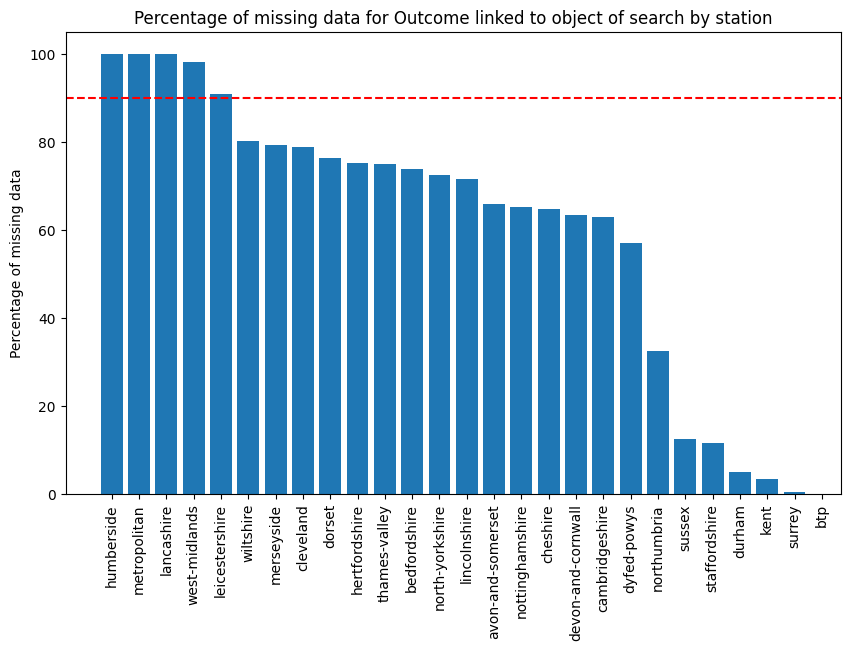

In [2]:
# Calculate the percentage of missing data for each station
missing_perc = df[df['Outcome linked to object of search'].isna()].groupby('station').size() / df.groupby('station').size() * 100

# Sort the stations by percentage of missing data
missing_perc = missing_perc.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x=missing_perc.index, height=missing_perc.values)
plt.xticks(rotation=90)
plt.ylabel('Percentage of missing data')
plt.title('Percentage of missing data for Outcome linked to object of search by station')

# Add a horizontal line at 95%
plt.axhline(y=90, color='r', linestyle='--')

plt.show()


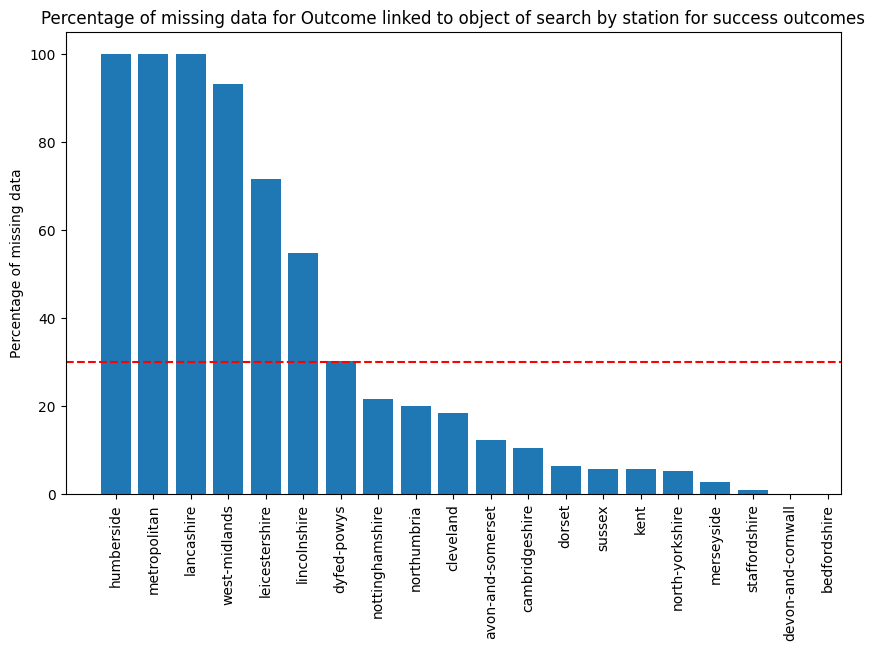

In [3]:
success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']

# Filter the dataframe to include only the success outcomes specified
df_success_outcomes = df[df['Outcome'].isin(success_outcomes)]

# Group the dataframe by station and calculate the percentage of missing values for each station
missing_perc = df_success_outcomes[df_success_outcomes['Outcome linked to object of search'].isna()].groupby('station').size() / df_success_outcomes.groupby('station').size() * 100

# Sort the stations by percentage of missing data
missing_perc = missing_perc.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x=missing_perc.index, height=missing_perc.values)
plt.xticks(rotation=90)
plt.axhline(y=30, color='r', linestyle='--')

plt.ylabel('Percentage of missing data')
plt.title('Percentage of missing data for Outcome linked to object of search by station for success outcomes')
plt.show()


In [4]:
df_et = df.drop(df[df['station'].isin(['humberside', 'lancashire','metropolitan','west-midlands','leicestershire'])].index)
df_et.loc[ df_et['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False


In [5]:
def clean (df):
    
    df_ = df.copy()
    
    success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']
    
    df_['Outcome linked to object of search'] = df_['Outcome linked to object of search'].fillna(False)
    df_['Removal of more than just outer clothing'] = df_['Removal of more than just outer clothing'].fillna(False)

    df_['success'] = df_.apply(lambda x: 1 if x['Outcome'] in success_outcomes and x['Outcome linked to object of search'] == True else 0, axis=1)
    
    return df_

df_et = clean(df_et)


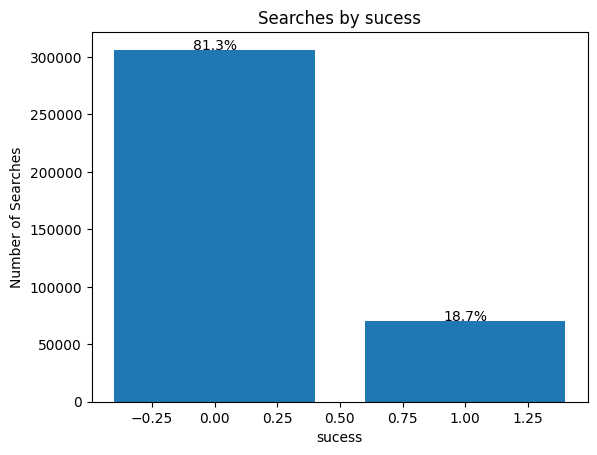

In [6]:
# count the number of searches for each gender
counts = df_et['success'].value_counts()

# create a bar plot
plt.bar(counts.index, counts.values)

# set the x-axis and y-axis labels
plt.xlabel('sucess')
plt.ylabel('Number of Searches')

# set the title of the plot
plt.title('Searches by sucess')

# add percentages to each bar
total = sum(counts.values)
for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v/total*100:.1f}%", ha='center')

# show the plot
plt.show()


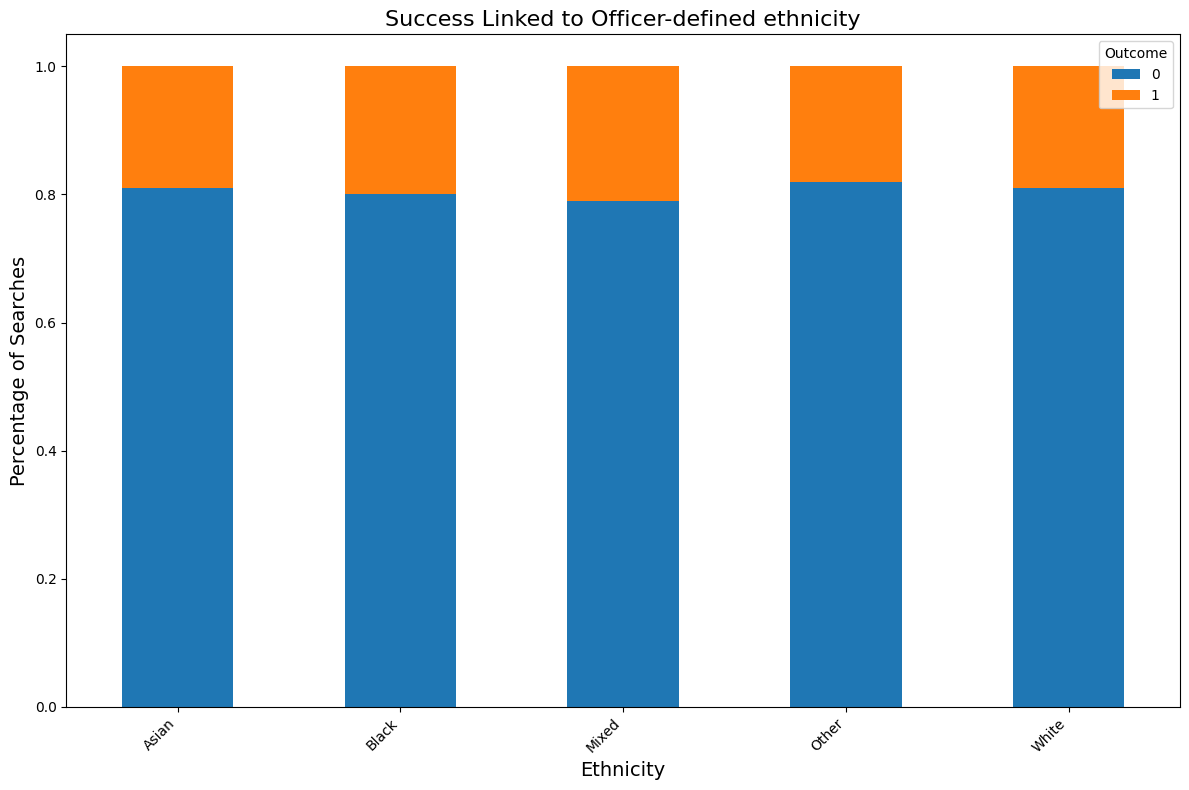

In [7]:
# Set a threshold for minimum number of searches per station and ethnicity
threshold = 30
data = df_et.copy()
# Get the counts of each ethnicity at each station
counts = data.groupby(['station', 'Officer-defined ethnicity','Gender']).size().reset_index(name='counts')
counts =  counts[counts["counts"] > threshold]

data = data.merge(counts[['station', 'Officer-defined ethnicity',"Gender"]], on=['station', 'Officer-defined ethnicity',"Gender"])

# Subset the dataframe to only include the columns of interest
ethnicity_outcome_df = data[['Officer-defined ethnicity', 'success']]

# Group the dataframe by ethnicity and outcome and calculate the count
ethnicity_outcome_count = ethnicity_outcome_df.groupby(['Officer-defined ethnicity', 'success']).size().reset_index(name='Count')

# Pivot the dataframe to have ethnicity as rows, outcome as columns, and count as values
ethnicity_outcome_pivot = ethnicity_outcome_count.pivot(index='Officer-defined ethnicity', columns='success', values='Count').fillna(0)

# Calculate the percentage of outcomes for each ethnicity
ethnicity_outcome_pct = ethnicity_outcome_pivot.div(ethnicity_outcome_pivot.sum(axis=1), axis=0).round(2)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ethnicity_outcome_pct.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Success Linked to Officer-defined ethnicity', fontsize=16)
ax.set_xlabel('Ethnicity', fontsize=14)
ax.set_ylabel('Percentage of Searches', fontsize=14)
ax.legend(title='Outcome', loc='upper right')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


In [8]:
def is_problematic(row):
    max_val = row.max()
    min_val = row.min()
    return max_val - min_val > 0.05

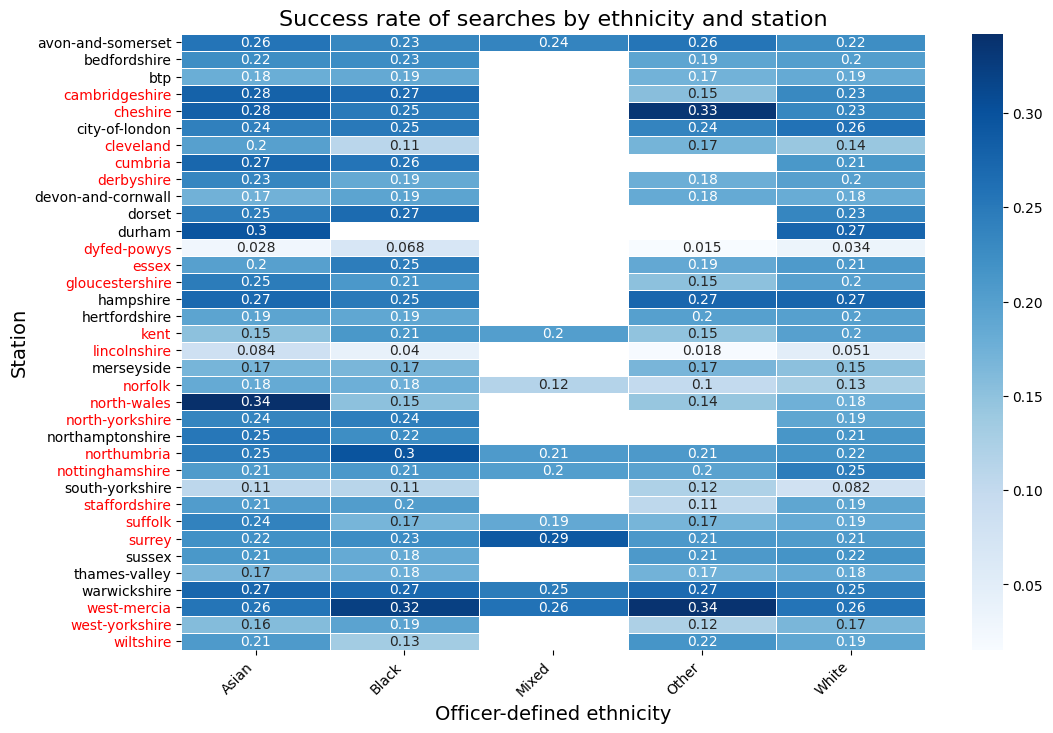

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select relevant columns
data = df_et[['station', 'Officer-defined ethnicity', 'success',"Gender"]]

# Set a threshold for minimum number of searches per station and ethnicity
threshold = 30

# Get the counts of each ethnicity at each station
counts = data.groupby(['station', 'Officer-defined ethnicity','Gender']).size().reset_index(name='counts')
counts =  counts[counts["counts"] > threshold]

data = data.merge(counts[['station', 'Officer-defined ethnicity',"Gender"]], on=['station', 'Officer-defined ethnicity',"Gender"])


# Order the Officer-defined ethnicity by 'White' first
ethnicity_order = ['White', 'Asian', 'Black', 'Mixed', 'Other']
data['Officer-defined ethnicity'] = pd.Categorical(data['Officer-defined ethnicity'], 
                                                          categories=ethnicity_order[::], 
                                                          ordered=True)

data['Officer-defined ethnicity'] = data['Officer-defined ethnicity'].astype(str)

# Pivot data
pivot_data = data.pivot_table(index='station', columns='Officer-defined ethnicity', 
                              values='success', aggfunc='mean')


data_test=  pivot_data.copy()
# Convert categorical column to string column

# Create new column with True/False values
data_test['problematic'] = data_test.apply(is_problematic, axis=1)

highlight_stations  = data_test[data_test['problematic']].index.tolist()

# Create heatmap
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5, ax=ax)



# Set plot title and axis labels
ax.set_title('Success rate of searches by ethnicity and station', fontsize=16)
ax.set_xlabel('Officer-defined ethnicity', fontsize=14)

ax.set_ylabel('Station', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

tick_labels = ax.get_yticklabels()
for label in tick_labels:
    if label.get_text() in highlight_stations:
        label.set_color('red')
    else:
        label.set_color('black')


plt.show()

In [10]:
data['Officer-defined ethnicity'].unique()

array(['White', 'Other', 'Asian', 'Black', 'Mixed'], dtype=object)

In [11]:
def is_problematic(row):
    max_val = row.max()
    min_val = row.min()
    return max_val - min_val > 0.05

# Convert categorical column to string column
data['Officer-defined ethnicity'] = data['Officer-defined ethnicity'].astype(str)

# Pivot the data
pivot_data = data.pivot_table(index='station', columns='Officer-defined ethnicity', 
                              values='success', aggfunc='mean')

# Create new column with True/False values
pivot_data['problematic'] = pivot_data.apply(is_problematic, axis=1)

problematic_stations = pivot_data[pivot_data['problematic']].index.tolist()
print(problematic_stations)
#pivot_data



['cambridgeshire', 'cheshire', 'cleveland', 'cumbria', 'derbyshire', 'dyfed-powys', 'essex', 'gloucestershire', 'kent', 'lincolnshire', 'norfolk', 'north-wales', 'north-yorkshire', 'northumbria', 'nottinghamshire', 'staffordshire', 'suffolk', 'surrey', 'west-mercia', 'west-yorkshire', 'wiltshire']


Based on the data you provided, there are a few stations that stand out in terms of having particularly high disparities in the success rates of searches among different ethnicities. These include:

Dorset: This station has a success rate of only 5% for searches on individuals of "Other" ethnicity, compared to success rates of around 23-27% for searches on individuals of other ethnicities.

Durham: This station has a success rate of 43% for searches on individuals of "Other" ethnicity, which is much higher than the success rates of around 22-28% for searches on individuals of other ethnicities.

Kent: This station has a success rate of only 15% for searches on individuals of "Other" ethnicity, compared to success rates of around 19-21% for searches on individuals of other ethnicities.

Northumbria: This station has a success rate of around 20% for searches on individuals of Mixed ethnicity, compared to success rates of around 25-30% for searches on individuals of other ethnicities.

Surrey: This station has a success rate of around 23% for searches on individuals of Mixed ethnicity, compared to success rates of around 22-31% for searches on individuals of other ethnicities.

West Mercia: This station has a success rate of around 26-32% for searches on individuals of Mixed ethnicity, compared to success rates of around 26% for searches on individuals of other ethnicities.

It's important to note that the presence of disparities in the success rates of searches does not necessarily indicate intentional discrimination on the part of the police. There may be a range of factors that contribute to these disparities, including unconscious biases, differences in the circumstances of searches, and differences in the underlying patterns of criminal activity in different ethnic groups. However, identifying these disparities is an important first step in addressing any potential issues of discrimination and promoting more equitable policing practices.

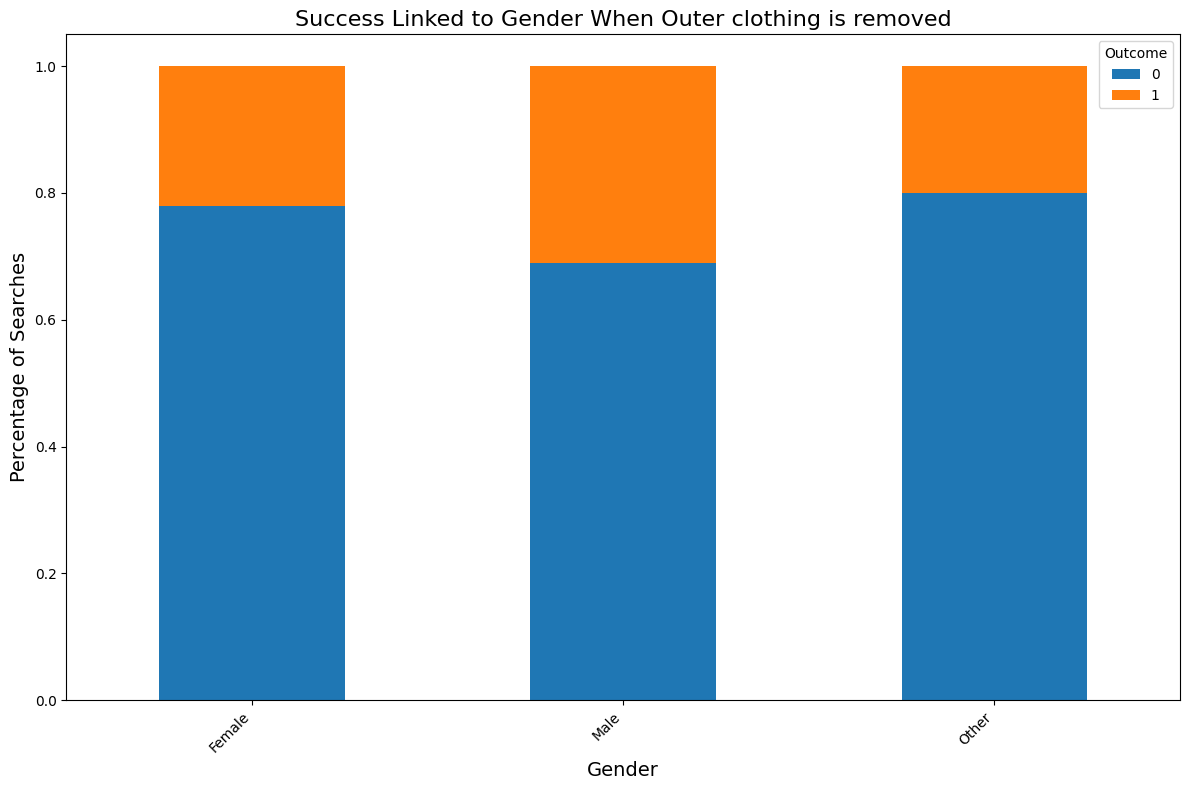

In [12]:
# Subset the dataframe to only include the columns of interest
later_df = df_et.copy()

later_df=later_df[later_df["Removal of more than just outer clothing"]==True]
ethnicity_outcome_df = later_df[['Gender', 'success']]

# Group the dataframe by ethnicity and outcome and calculate the count
ethnicity_outcome_count = ethnicity_outcome_df.groupby(['Gender', 'success']).size().reset_index(name='Count')

# Pivot the dataframe to have ethnicity as rows, outcome as columns, and count as values
ethnicity_outcome_pivot = ethnicity_outcome_count.pivot(index='Gender', columns='success', values='Count').fillna(0)

# Calculate the percentage of outcomes for each ethnicity
ethnicity_outcome_pct = ethnicity_outcome_pivot.div(ethnicity_outcome_pivot.sum(axis=1), axis=0).round(2)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ethnicity_outcome_pct.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Success Linked to Gender When Outer clothing is removed', fontsize=16)
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Percentage of Searches', fontsize=14)
ax.legend(title='Outcome', loc='upper right')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


check if officer and self is very different data

## removal of clothing 

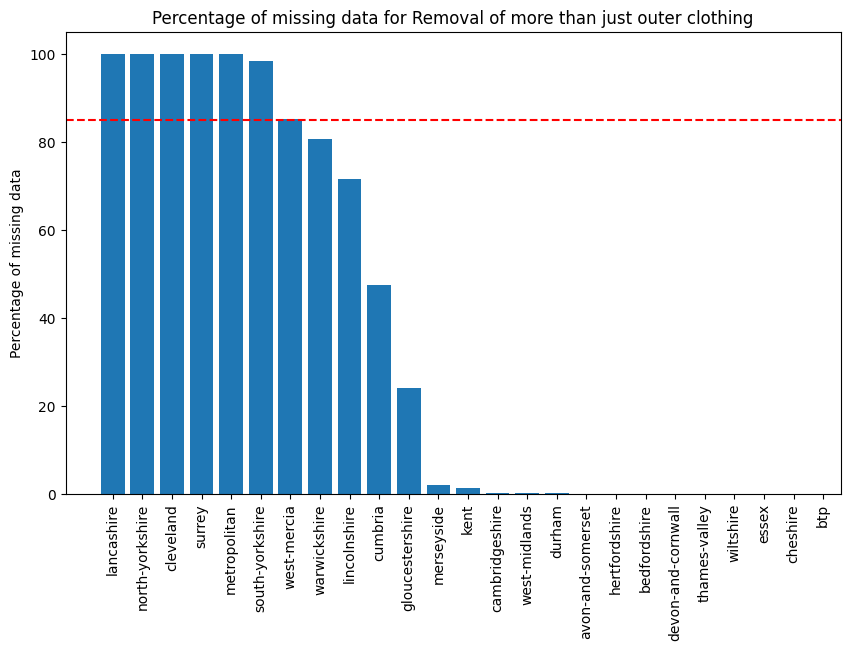

In [13]:
# Calculate the percentage of missing data for each station
missing_perc = df[df['Removal of more than just outer clothing'].isna()].groupby('station').size() / df.groupby('station').size() * 100

# Sort the stations by percentage of missing data
missing_perc = missing_perc.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x=missing_perc.index, height=missing_perc.values)
plt.xticks(rotation=90)
plt.ylabel('Percentage of missing data')
plt.title('Percentage of missing data for Removal of more than just outer clothing')

# Add a horizontal line at 95%
plt.axhline(y=85, color='r', linestyle='--')

plt.show()

In [14]:
# Find stations where the "Outcome linked to object of search" is completely missing
df_new = df.drop(df[df['station'].isin(['humberside', 'lancashire','metropolitan','west-midlands','leicestershire'])].index)
df_new.loc[ df_new['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False

stations_to_drop = df_new[df_new.groupby('station')['Removal of more than just outer clothing'].transform('count')==0]['station'].unique()

# Drop the stations from the dataframe
df_rc1 = df_new[~df_new['station'].isin(stations_to_drop)]
print("The stations droped were:",stations_to_drop)
print('humberside', 'lancashire','metropolitan','west-midlands',"leicestershire")

The stations droped were: ['surrey' 'north-yorkshire' 'cleveland']
humberside lancashire metropolitan west-midlands leicestershire


In [15]:
def clean_RC (df):
    
    df_ = df.copy()
    
    success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']
    
    df_= df_[df_['Gender']=="Female"]
    
    df_['Outcome linked to object of search'] = df_['Outcome linked to object of search'].fillna(False)
    df_['Removal of more than just outer clothing'] = df_['Removal of more than just outer clothing'].fillna(False)
    df_['success'] = df_.apply(lambda x: 1 if x['Outcome'] in success_outcomes and x['Outcome linked to object of search'] == True else 0, axis=1)
    
    return df_

df_rc = clean_RC(df_rc1)


In [23]:
df_rc.dtypes

observation_id                               object
Type                                         object
Date                                         object
Part of a policing operation                 object
Latitude                                    float64
Longitude                                   float64
Gender                                       object
Age range                                    object
Self-defined ethnicity                       object
Officer-defined ethnicity                    object
Legislation                                  object
Object of search                             object
Outcome                                      object
Outcome linked to object of search             bool
Removal of more than just outer clothing       bool
station                                      object
success                                       int64
dtype: object

observation_id                               object
Type                                         object
Date                                         object
Part of a policing operation                 object
Latitude                                    float64
Longitude                                   float64
Gender                                       object
Age range                                    object
Self-defined ethnicity                       object
Officer-defined ethnicity                    object
Legislation                                  object
Object of search                             object
Outcome                                      object
Outcome linked to object of search           object
Removal of more than just outer clothing     object
station                                      object

this is my dataset 
i have cleaned it so i also have the column sucess that is 1 if the search was sucessfull and 0 if it was not
i also only got the people with the gender == 'Female'

i want to build a graph using the columns "Age range" , "success" and "Officer-defined ethnicity"

the values in "Age range" are  ['25-34', 'over 34', '10-17', '18-24', 'under 10']
the values in "Officer-defined ethnicity" are ['White', 'Other', 'Asian', 'Black', 'Mixed']

i want to build a plot
the x axis will have the Age range 
the y will have the Percentage of searches 
each value on the age range will have 5 columns corresponding to each of "Officer-defined ethnicity" 
can u give me the code for it

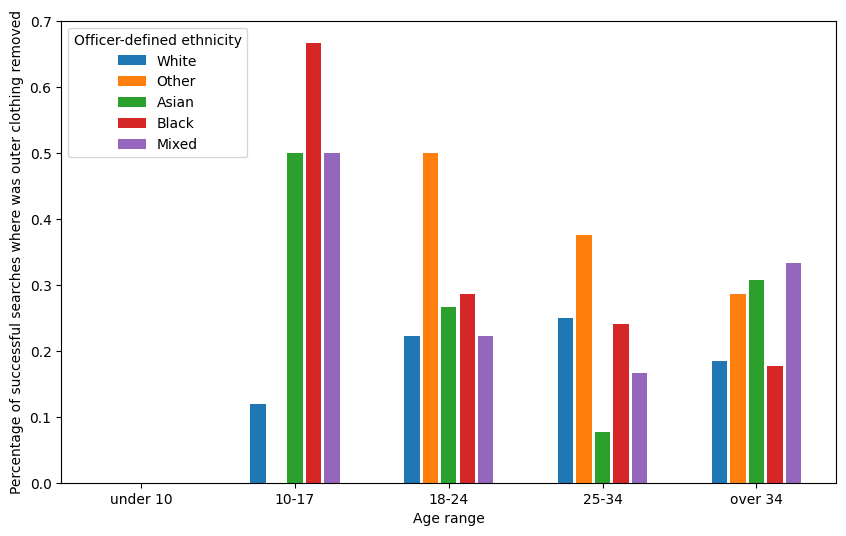

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# filter the data for females only
df_females = df_rc[ (df_rc['Gender'] == 'Female') & (df_rc['Removal of more than just outer clothing'] == True) ]

# define the age ranges and officer-defined ethnicity values
age_ranges = ['under 10', '10-17', '18-24', '25-34', 'over 34']
ethnicities = ['White', 'Other', 'Asian', 'Black', 'Mixed']


# Set a threshold for minimum number of searches per station and ethnicity
threshold = 0

# Get the counts of each ethnicity at each station
counts = df_females.groupby(['station', 'Officer-defined ethnicity']).size().reset_index(name='counts')
counts =  counts[counts["counts"] > threshold]

df_females = df_females.merge(counts[['station', 'Officer-defined ethnicity']], on=['station', 'Officer-defined ethnicity'])



# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# set the bar width and gap between the bars
width = 0.1
gap = 0.02

# loop through each ethnicity and plot the bars for each age range
for i, ethnicity in enumerate(ethnicities):
    # get the subset of data for the current ethnicity
    ethnicity_data = df_females[df_females['Officer-defined ethnicity'] == ethnicity]
    # create a list to store the success rates for each age range
    success_rates = []
    for age_range in age_ranges:
        # get the subset of data for the current age range
        age_data = ethnicity_data[ethnicity_data['Age range'] == age_range]
        # filter the data for successful searches where "Removal of more than just outer clothing" is True
        success_data = age_data[(age_data['success'] == 1) & (age_data['Removal of more than just outer clothing'] == True)]
        # calculate the success rate for the current age range and ethnicity
        success_rate = success_data.shape[0] / age_data.shape[0] if age_data.shape[0] > 0 else 0
        success_rates.append(success_rate)
    # plot the bars for the current ethnicity and age range
    x_pos = np.arange(len(age_ranges)) + i * (width + gap)
    ax.bar(x_pos, success_rates, width=width, label=ethnicity)

# add the x and y axis labels and the legend
ax.set_xlabel('Age range')
ax.set_ylabel('Percentage of successful searches where was outer clothing removed')
ax.set_xticks(np.arange(len(age_ranges)) + ((len(ethnicities) - 1) / 2) * (width + gap))
ax.set_xticklabels(age_ranges)
ax.legend(title='Officer-defined ethnicity', loc='upper left')

# show the plot
plt.show()



In [19]:
#ver cada area taxa de crime em diferentes areas 
# comprar sucess rates com numero actuall de positive outcomes
#mais chances de uma etnia ter interveçao policial sem razao para a procura 

[]


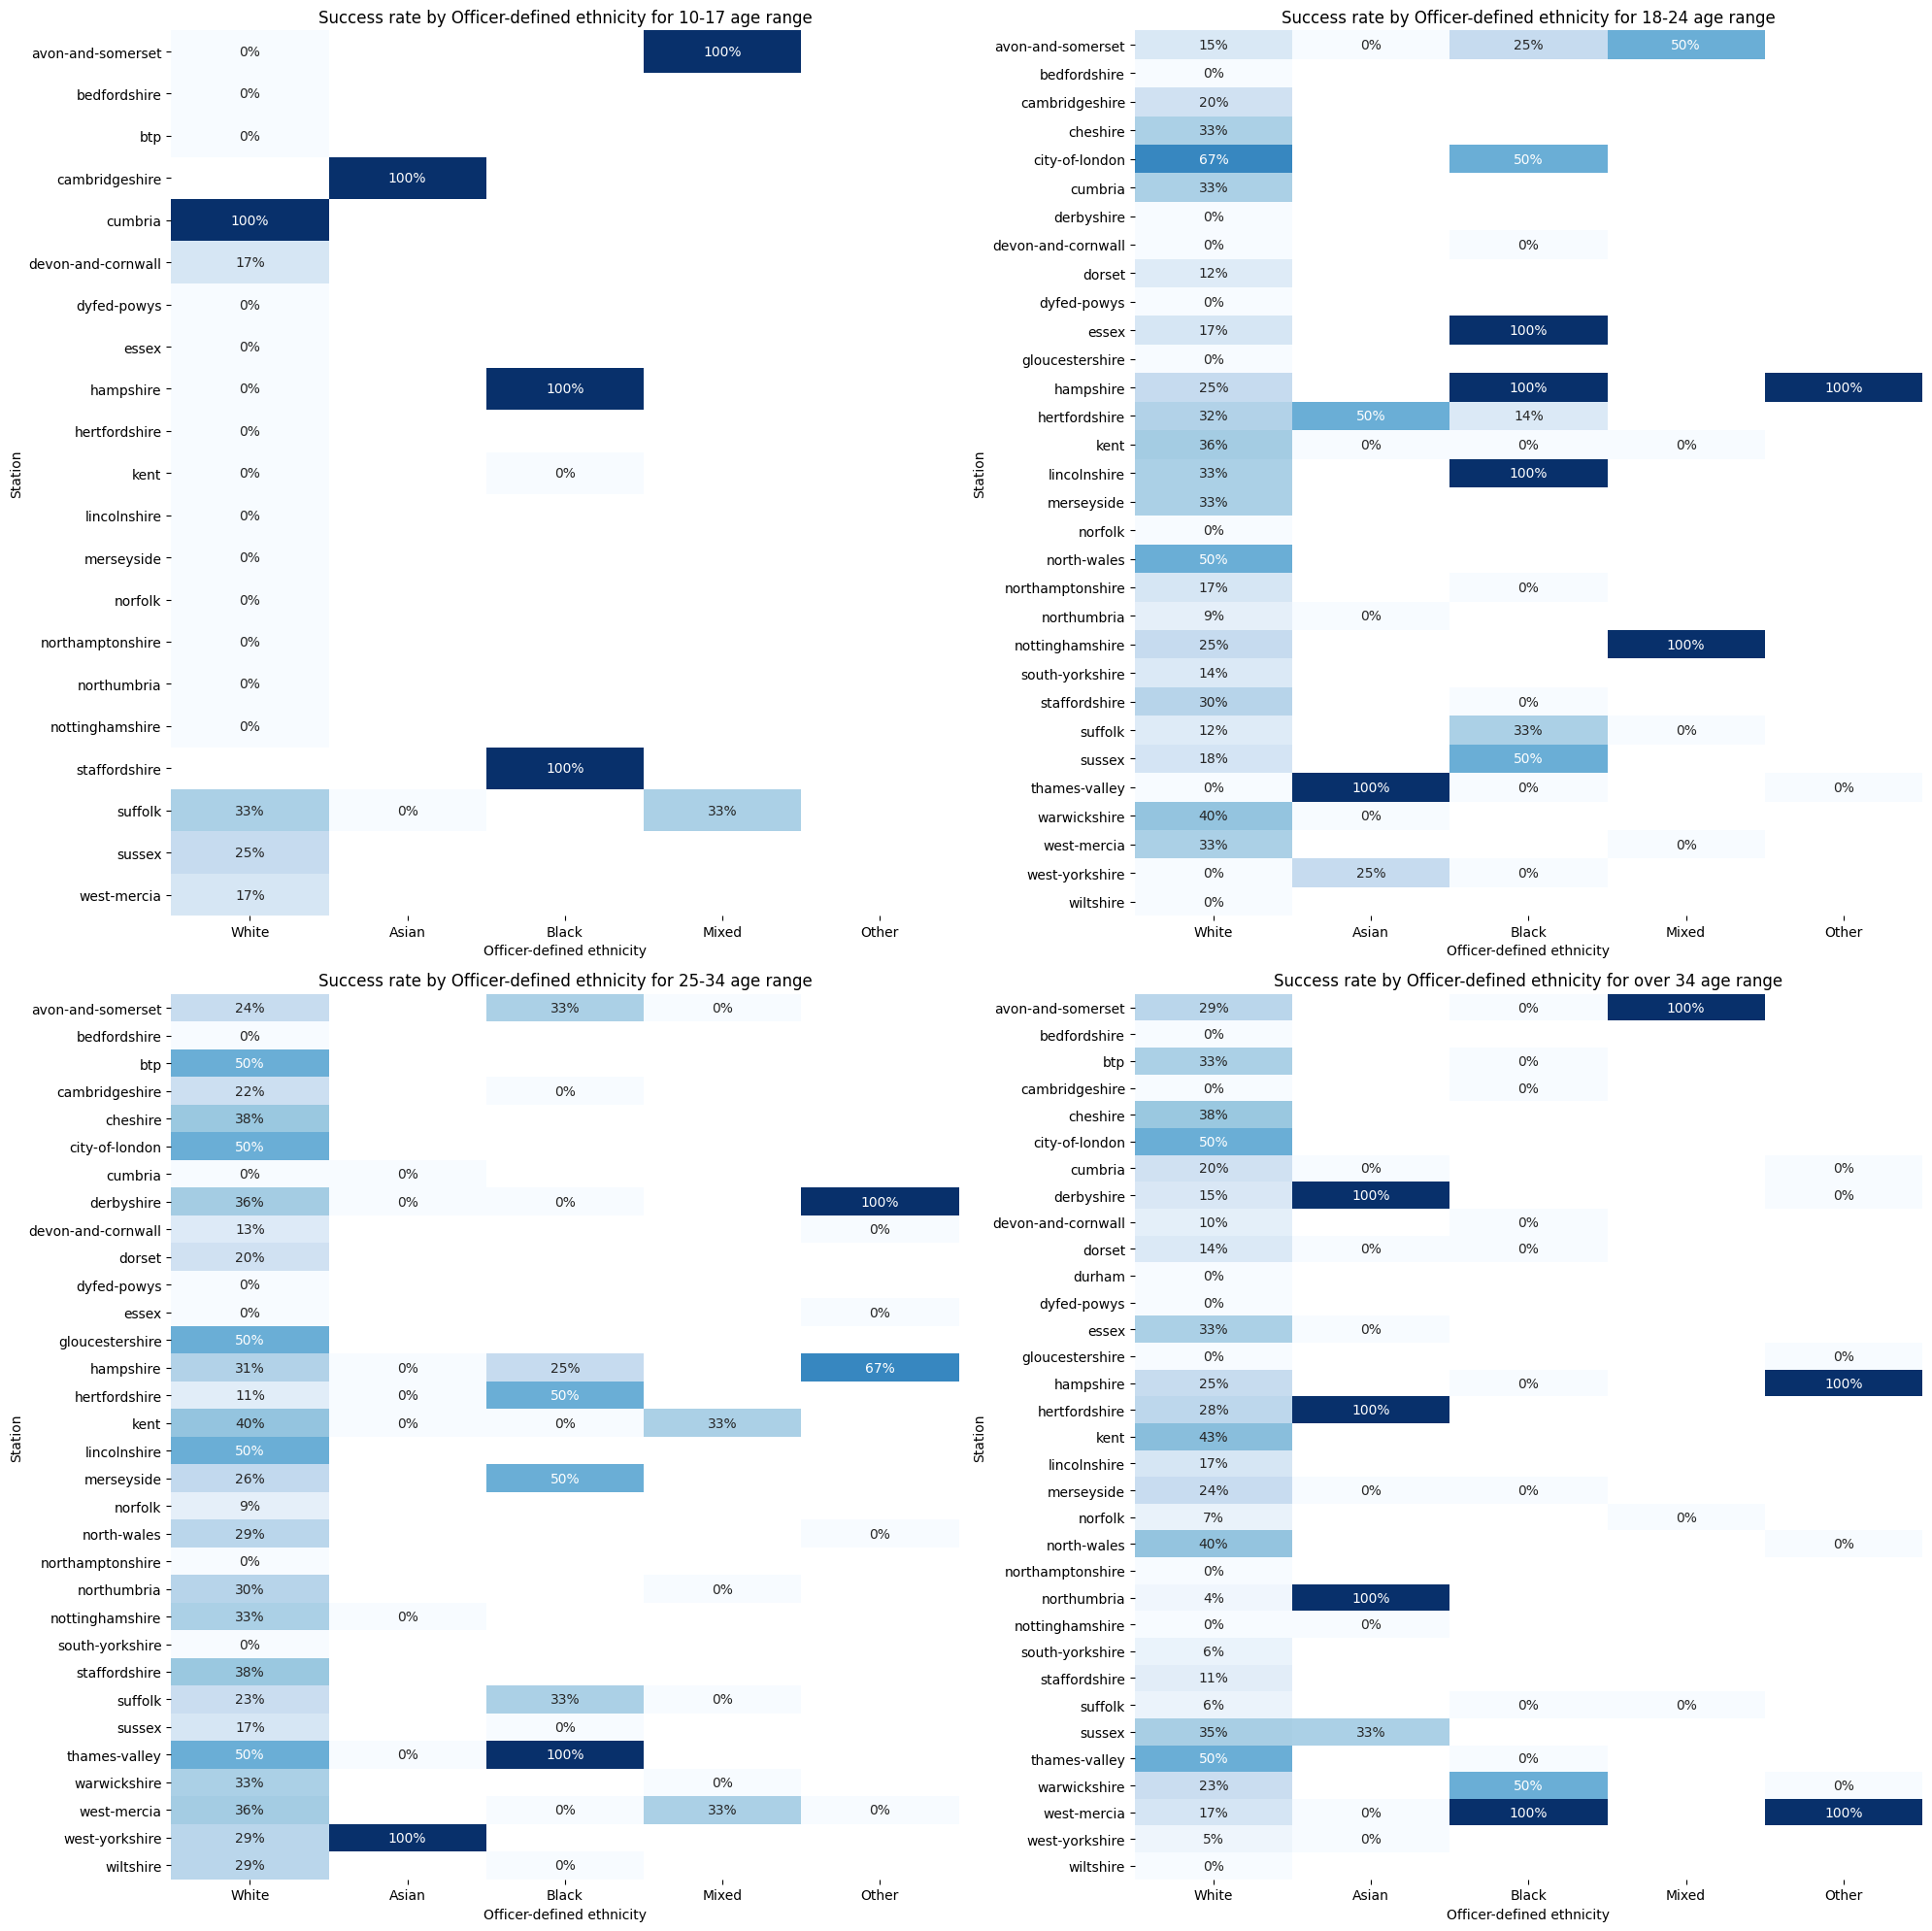

In [20]:
df_filtered = df_females.copy()

# List of age ranges
age_ranges = ['10-17', '18-24', '25-34', 'over 34']

# Order the Officer-defined ethnicity by 'White' first
ethnicity_order = ['White', 'Asian', 'Black', 'Mixed', 'Other']
df_filtered['Officer-defined ethnicity'] = pd.Categorical(df_filtered['Officer-defined ethnicity'], 
                                                          categories=ethnicity_order[::], 
                                                          ordered=True)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))


problematic_stations = []
for i, ax in enumerate(axes.flatten()):
    # Filter by age range
    df_age = df_filtered[df_filtered['Age range'] == age_ranges[i]]

    # Calculate percentage success for each combination of station and ethnicity
    df_pivot = df_age.groupby(['station', 'Officer-defined ethnicity']).agg({'success': 'mean'}).reset_index().pivot(index='station', columns='Officer-defined ethnicity', values='success')

    #print(df_pivot)
    '''df_bla =df_pivot.copy()
    # Create new column with True/False values
    df_bla['problematic'] = df_bla.apply(is_problematic, axis=1)
    print("here")
    p_s = df_bla[df_bla['problematic']].index.tolist()
    for s in p_s:
        if s not in problematic_stations:
            problematic_stations.append(s)
    '''
    
    
    # Plot heatmap
    sns.heatmap(df_pivot, cmap='Blues', annot=True, fmt='.0%', cbar=False, ax=ax)
    ax.set_title(f"Success rate by Officer-defined ethnicity for {age_ranges[i]} age range")
    ax.set_xlabel("Officer-defined ethnicity")
    ax.set_ylabel("Station")
print(problematic_stations)
plt.tight_layout()
plt.show()

In [21]:
len(problematic_stations)

0

Based on the data you provided, there are a few stations that stand out in terms of having particularly high disparities in the success rates of searches among different ethnicities. These include:

Dorset: This station has a success rate of only 5% for searches on individuals of "Other" ethnicity, compared to success rates of around 23-27% for searches on individuals of other ethnicities. Durham: This station has a success rate of 43% for searches on individuals of "Other" ethnicity, which is much higher than the success rates of around 22-28% for searches on individuals of other ethnicities. Kent: This station has a success rate of only 15% for searches on individuals of "Other" ethnicity, compared to success rates of around 19-21% for searches on individuals of other ethnicities. Northumbria: This station has a success rate of around 20% for searches on individuals of Mixed ethnicity, compared to success rates of around 25-30% for searches on individuals of other ethnicities. Surrey: This station has a success rate of around 23% for searches on individuals of Mixed ethnicity, compared to success rates of around 22-31% for searches on individuals of other ethnicities. West Mercia: This station has a success rate of around 26-32% for searches on individuals of Mixed ethnicity, compared to success rates of around 26% for searches on individuals of other ethnicities. It's important to note that the presence of disparities in the success rates of searches does not necessarily indicate intentional discrimination on the part of the police. There may be a range of factors that contribute to these disparities, including unconscious biases, differences in the circumstances of searches, and differences in the underlying patterns of criminal activity in different ethnic groups. However, identifying these disparities is an important first step in addressing any potential issues of discrimination and promoting more equitable policing practices.

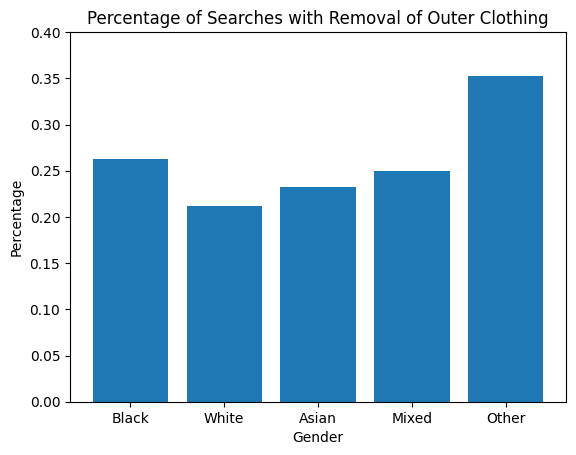

In [22]:
data = df_et.copy()
import matplotlib.pyplot as plt

# Create a subset of data where 'Removal of more than just outer clothing' is True
subset = df_females[df_females['success'] == 1]

# Group the subset by gender and count the number of searches
grouped = subset.groupby('Officer-defined ethnicity')['Officer-defined ethnicity'].count()

# Calculate the percentage of searches where outer clothing was removed separately for men and women
women_removed = grouped.loc['Black'] / df_females['Officer-defined ethnicity'].value_counts()['Black']
men_removed = grouped.loc['White'] / df_females['Officer-defined ethnicity'].value_counts()['White']
men_removed1 = grouped.loc['Asian'] / df_females['Officer-defined ethnicity'].value_counts()['Asian']
men_removed2 = grouped.loc['Mixed'] / df_females['Officer-defined ethnicity'].value_counts()['Mixed']
men_removed3 = grouped.loc['Other'] / df_females['Officer-defined ethnicity'].value_counts()['Other']

# Plot the results
plt.bar(['Black', 'White',"Asian",'Mixed',"Other"], [women_removed, men_removed,men_removed1,men_removed2,men_removed3])
plt.title('Percentage of Searches with Removal of Outer Clothing')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.ylim(0, 0.4)
plt.show()


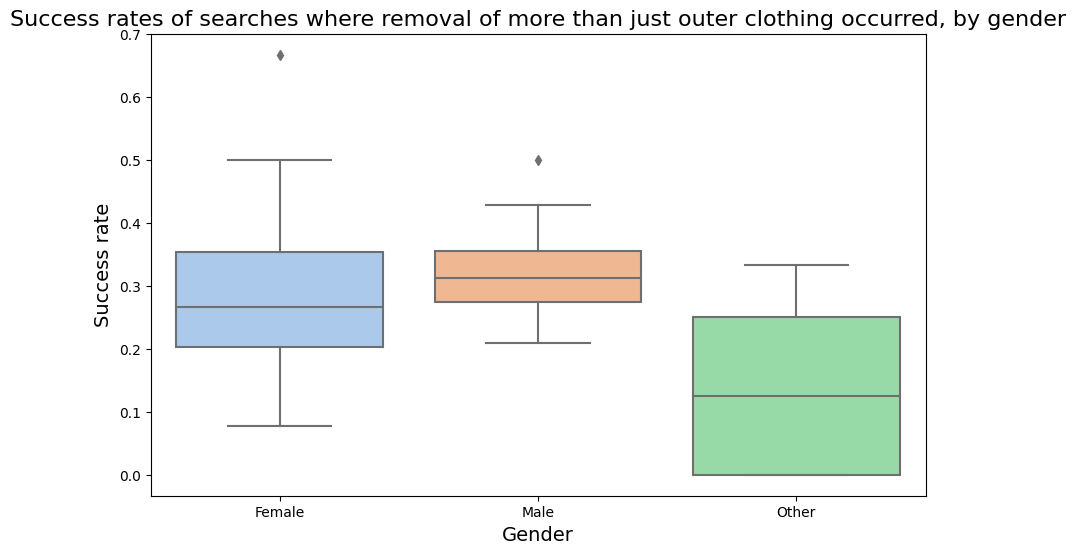

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Select relevant columns
data = df_et[['Gender', 'Age range', 'Officer-defined ethnicity', 'Removal of more than just outer clothing', 'success']]

# Filter data to include only searches where removal of more than just outer clothing occurred
data = data[data['Removal of more than just outer clothing'] == True]

# Calculate success rates separately for each gender
success_rates = data.groupby(['Gender', 'Age range', 'Officer-defined ethnicity'])['success'].mean().reset_index(name='success_rate')

# Create a boxplot of success rates for each gender
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x='Gender', y='success_rate', data=success_rates, palette='pastel', ax=ax)

# Set plot title and axis labels
ax.set_title('Success rates of searches where removal of more than just outer clothing occurred, by gender', fontsize=16)
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Success rate', fontsize=14)

plt.show()



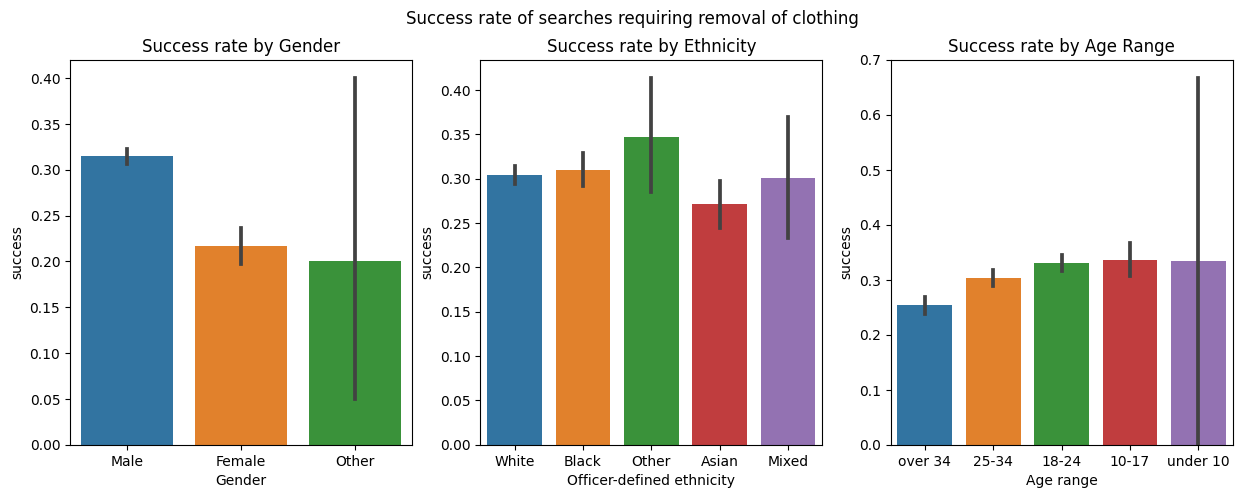

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
data = df_et[['Gender', "Officer-defined ethnicity", 'Age range', 'Removal of more than just outer clothing', 'success']]

# Filter the data to only include searches where removal of clothing was necessary
data = data[data['Removal of more than just outer clothing'] == True]

# Create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# Plot 1: success rate by gender
sns.barplot(x='Gender', y='success', data=data, ax=axs[0])
axs[0].set_title('Success rate by Gender')

# Plot 2: success rate by ethnicity
sns.barplot(x='Officer-defined ethnicity', y='success', data=data, ax=axs[1])
axs[1].set_title('Success rate by Ethnicity')

# Plot 3: success rate by age range
sns.barplot(x='Age range', y='success', data=data, ax=axs[2])
axs[2].set_title('Success rate by Age Range')

# Set the overall title of the figure
fig.suptitle('Success rate of searches requiring removal of clothing')

plt.show()


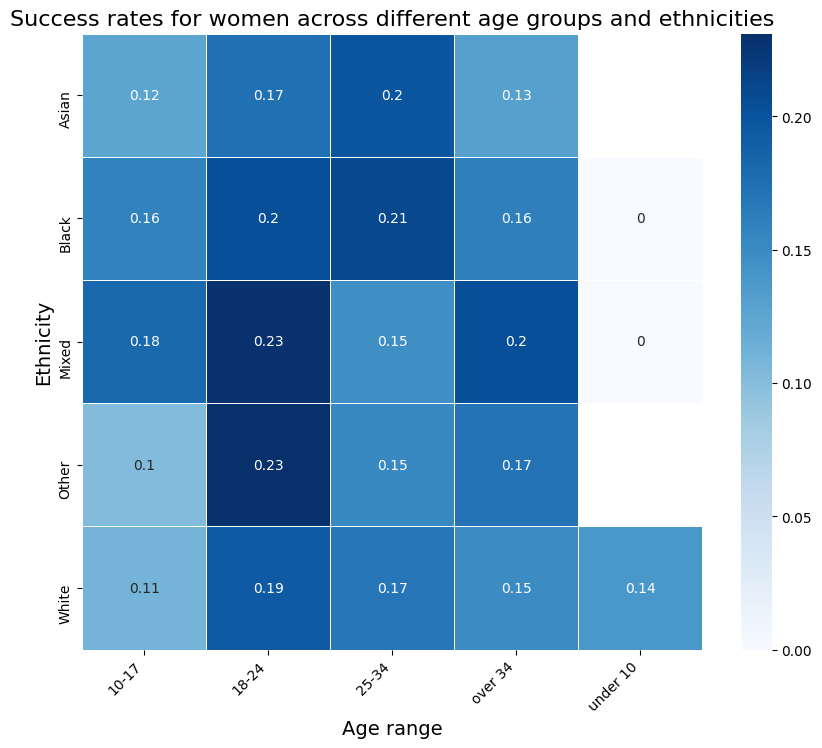

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for women only
df_women = df_et[df_et['Gender'] == 'Female']

# Create a pivot table to get the search rates for each ethnicity and age range
pivot_data = df_women.pivot_table(index='Officer-defined ethnicity', columns='Age range', 
                                  values='success', aggfunc='mean')

# Create heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pivot_data, cmap='Blues', annot=True, linewidths=.5, ax=ax)

# Set plot title and axis labels
ax.set_title('Success rates for women across different age groups and ethnicities', fontsize=16)
ax.set_xlabel('Age range', fontsize=14)
ax.set_ylabel('Ethnicity', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()


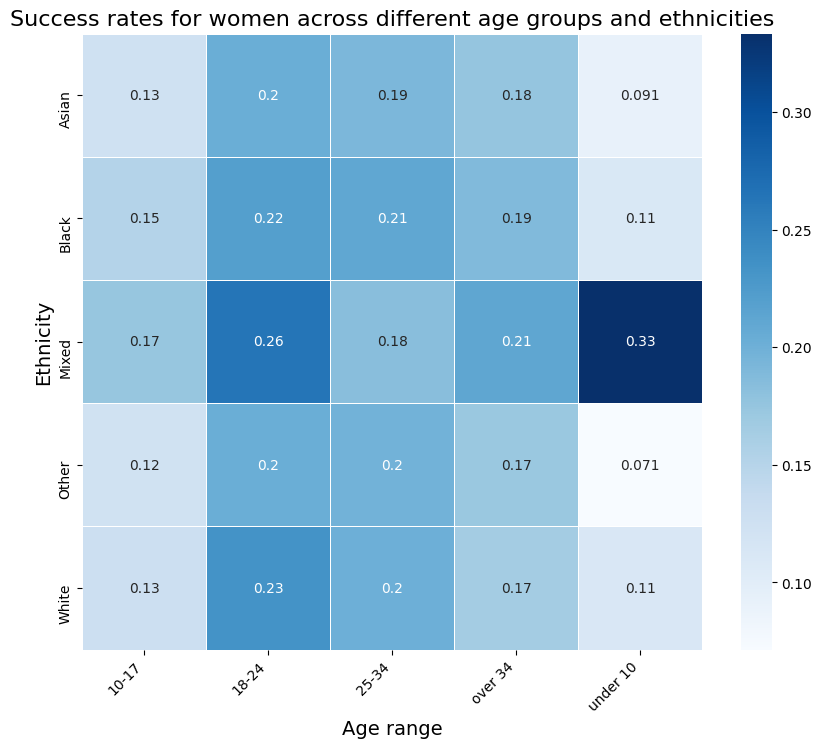

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for women only
df_women = df_et[df_et['Gender'] == 'Male']

# Create a pivot table to get the search rates for each ethnicity and age range
pivot_data = df_women.pivot_table(index='Officer-defined ethnicity', columns='Age range', 
                                  values='success', aggfunc='mean')

# Create heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pivot_data, cmap='Blues', annot=True, linewidths=.5, ax=ax)

# Set plot title and axis labels
ax.set_title('Success rates for women across different age groups and ethnicities', fontsize=16)
ax.set_xlabel('Age range', fontsize=14)
ax.set_ylabel('Ethnicity', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()